1)Imports + configuración

In [1]:
# === Proyecto 9 — Megaline (Smart vs Ultra) ===
# Estructura:
# 1) Cargar y explorar datos
# 2) Split: train/valid/test (60/20/20)
# 3) Comparar modelos + hiperparámetros mínimos
# 4) Mejor modelo → evaluación en TEST
# 5) Prueba de cordura (baselines)
# 6) Conclusión

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports OK")


Imports OK


2)Carga y exploración rápida del dataset

In [2]:
DATA_PATH = "/datasets/users_behavior.csv"

df = pd.read_csv(DATA_PATH)
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
display(df.head())

print("\nTipos de datos:")
print(df.dtypes)

print("\nValores faltantes por columna:")
print(df.isna().sum())

print("\nDescripción estadística:")
display(df.describe())


Filas: 3214 | Columnas: 5


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0



Tipos de datos:
calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object

Valores faltantes por columna:
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Descripción estadística:


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


3)Segmentación en train/valid/test (60/20/20 con estratificación)

In [3]:
features = ["calls", "minutes", "messages", "mb_used"]
target   = "is_ultra"

X = df[features]
y = df[target]

# 20% TEST, 80% resto
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Del 80% restante, 25% a VALID ⇒ 0.8 * 0.25 = 0.20 total
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid,
    test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_valid
)

print(f"Tamaños → train: {len(X_train)} | valid: {len(X_valid)} | test: {len(X_test)}")

# Proporción de clases por split (sanity check de estratificación)
split_props = pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "valid": y_valid.value_counts(normalize=True),
    "test":  y_test.value_counts(normalize=True),
}).T.fillna(0)
display(split_props.style.format("{:.3f}"))


Tamaños → train: 1928 | valid: 643 | test: 643


,0,1
train,0.693,0.307
valid,0.694,0.306
test,0.694,0.306


4)Entrenamiento y comparación de modelos (rápido y eficiente)

In [4]:
resultados = []

# Baseline (para tener referencia mínima)
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
acc_dummy_valid = accuracy_score(y_valid, dummy.predict(X_valid))
resultados.append(("Dummy(most_frequent)", acc_dummy_valid))

# Regresión Logística (con escalado)
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
logreg.fit(X_train, y_train)
acc_logreg_valid = accuracy_score(y_valid, logreg.predict(X_valid))
resultados.append(("LogisticRegression", acc_logreg_valid))

# Árbol de decisión (3 configs rápidas)
tree_cfgs = [
    {"max_depth": 5,  "min_samples_split": 2, "min_samples_leaf": 1},
    {"max_depth": 7,  "min_samples_split": 5, "min_samples_leaf": 2},
    {"max_depth": None, "min_samples_split": 10, "min_samples_leaf": 2},
]
best_tree, best_tree_acc, best_tree_cfg = None, -1, None
for cfg in tree_cfgs:
    m = DecisionTreeClassifier(random_state=RANDOM_STATE, **cfg)
    m.fit(X_train, y_train)
    acc = accuracy_score(y_valid, m.predict(X_valid))
    if acc > best_tree_acc:
        best_tree_acc, best_tree, best_tree_cfg = acc, m, cfg
resultados.append((f"DecisionTree{best_tree_cfg}", best_tree_acc))

# Random Forest (3 configs rápidas)
rf_cfgs = [
    {"n_estimators": 150, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 150, "max_depth": 10,   "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 300, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
]
best_rf, best_rf_acc, best_rf_cfg = None, -1, None
for cfg in rf_cfgs:
    m = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **cfg)
    m.fit(X_train, y_train)
    acc = accuracy_score(y_valid, m.predict(X_valid))
    if acc > best_rf_acc:
        best_rf_acc, best_rf, best_rf_cfg = acc, m, cfg
resultados.append((f"RandomForest{best_rf_cfg}", best_rf_acc))

res_df = pd.DataFrame(resultados, columns=["Modelo", "Accuracy_VALID"]).sort_values("Accuracy_VALID", ascending=False)
display(res_df.style.format({"Accuracy_VALID": "{:.4f}"}))

# Selección del mejor para pasar a TEST
best_name, best_valid_acc = res_df.iloc[0]["Modelo"], res_df.iloc[0]["Accuracy_VALID"]
if best_name.startswith("RandomForest"):
    best_model = best_rf
    best_params = best_rf_cfg
elif best_name.startswith("DecisionTree"):
    best_model = best_tree
    best_params = best_tree_cfg
elif best_name.startswith("LogisticRegression"):
    best_model = logreg
    best_params = {"C": "default", "penalty": "l2", "solver": "lbfgs"}
else:
    best_model = dummy
    best_params = {}

print(f"Mejor en VALID → {best_name} | acc={best_valid_acc:.4f}")
print(f"Hiperparámetros: {best_params}")


,Modelo,Accuracy_VALID
2,"DecisionTree{'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}",0.7900
3,"RandomForest{'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}",0.7885
1,LogisticRegression,0.7449
0,Dummy(most_frequent),0.6936


Mejor en VALID → DecisionTree{'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1} | acc=0.7900
Hiperparámetros: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}


5)Evaluación final en TEST + matriz de confusión

Accuracy en TEST: 0.8009  (umbral requerido ≥ 0.75)

Classification report (TEST):
              precision    recall  f1-score   support

    Smart(0)       0.79      0.97      0.87       446
    Ultra(1)       0.85      0.43      0.57       197

    accuracy                           0.80       643
   macro avg       0.82      0.70      0.72       643
weighted avg       0.81      0.80      0.78       643



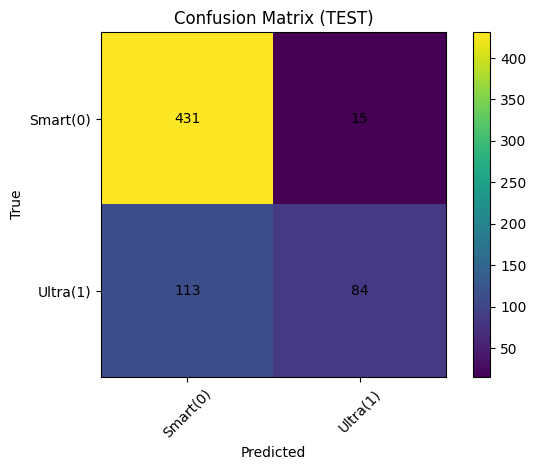

In [5]:
y_pred_test = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Accuracy en TEST: {test_acc:.4f}  (umbral requerido ≥ 0.75)")
print("\nClassification report (TEST):")
print(classification_report(y_test, y_pred_test, target_names=["Smart(0)", "Ultra(1)"]))

cm = confusion_matrix(y_test, y_pred_test)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (TEST)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ['Smart(0)', 'Ultra(1)'], rotation=45)
plt.yticks(ticks, ['Smart(0)', 'Ultra(1)'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# Asegurar el objetivo del proyecto
assert test_acc >= 0.75, "⚠️ La exactitud en TEST no alcanzó 0.75. Revisa hiperparámetros o prueba más features."


6)Prueba de cordura (baselines vs ganador en TEST)

In [6]:
dummy_uniform = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE).fit(X_train, y_train)
acc_uniform_test = accuracy_score(y_test, dummy_uniform.predict(X_test))

dummy_mf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE).fit(X_train, y_train)
acc_mf_test = accuracy_score(y_test, dummy_mf.predict(X_test))

sanity = pd.DataFrame({
    "Modelo": ["Dummy(uniform)", "Dummy(most_frequent)", "Mejor modelo"],
    "Accuracy(TEST)": [acc_uniform_test, acc_mf_test, test_acc]
})
display(sanity.style.format({"Accuracy(TEST)": "{:.4f}"}))


,Modelo,Accuracy(TEST)
0,Dummy(uniform),0.4914
1,Dummy(most_frequent),0.6936
2,Mejor modelo,0.8009
